# F1 Grand Prix Win Probability Prediction

This notebook predicts the winning probability for each driver in Grand Prix races using historical F1 data.

## Pipeline Overview:
1. **Data Preparation** - Load and engineer features from OpenF1 API data
2. **Model Training** - Train machine learning models to predict win probabilities
3. **Analysis** - Evaluate model performance and analyze win probabilities for each driver

## Step 1: Data Preparation

In [104]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


### 1.1 Load Data

In [105]:
# Load all datasets
print("Loading datasets...")

drivers = pd.read_csv('data/drivers.csv')
sessions = pd.read_csv('data/sessions.csv')
meetings = pd.read_csv('data/meetings.csv')
laps = pd.read_csv('data/laps.csv')
position = pd.read_csv('data/position.csv')
pit = pd.read_csv('data/pit.csv')
stints = pd.read_csv('data/stints.csv')
weather = pd.read_csv('data/weather.csv')
session_result = pd.read_csv('data/session_result.csv')
starting_grid = pd.read_csv('data/starting_grid.csv')

print(f"✓ Drivers: {len(drivers)} records")
print(f"✓ Sessions: {len(sessions)} records")
print(f"✓ Meetings: {len(meetings)} records")
print(f"✓ Laps: {len(laps)} records")
print(f"✓ Position: {len(position)} records")
print(f"✓ Pit stops: {len(pit)} records")
print(f"✓ Stints: {len(stints)} records")
print(f"✓ Weather: {len(weather)} records")
print(f"✓ Session results: {len(session_result)} records")
print(f"✓ Starting grid: {len(starting_grid)} records")

Loading datasets...
✓ Drivers: 7125 records
✓ Sessions: 123 records
✓ Meetings: 25 records
✓ Laps: 1156 records
✓ Position: 666 records
✓ Pit stops: 24213 records
✓ Stints: 28021 records
✓ Weather: 153 records
✓ Session results: 7063 records
✓ Starting grid: 1734 records


In [106]:
# Check session_result columns to see if it has grid position
print("\nSession result columns:")
print(session_result.columns.tolist())
print("\nSample session_result data:")
print(session_result.head())


Session result columns:
['position', 'driver_number', 'number_of_laps', 'dnf', 'dns', 'dsq', 'duration', 'gap_to_leader', 'meeting_key', 'session_key', 'points']

Sample session_result data:
   position  driver_number  number_of_laps    dnf    dns    dsq duration  \
0       1.0             11            21.0  False  False  False   92.758   
1       2.0             14            22.0  False  False  False   93.196   
2       3.0              1            21.0  False  False  False   93.375   
3       4.0              4            21.0  False  False  False   94.165   
4       5.0             16            17.0  False  False  False   94.257   

  gap_to_leader  meeting_key  session_key  points  
0             0         1141         7765     NaN  
1         0.438         1141         7765     NaN  
2         0.617         1141         7765     NaN  
3         1.407         1141         7765     NaN  
4         1.499         1141         7765     NaN  


In [107]:
# Check starting_grid and see if we can find qualifying sessions
print("\nStarting grid columns:")
print(starting_grid.columns.tolist())
print(f"\nSample starting_grid session_keys: {starting_grid['session_key'].unique()[:5]}")
print(f"\nRace session_keys: {race_sessions['session_key'].unique()[:5]}")

# Check if we have qualifying sessions that match our race sessions
qualifying_sessions = sessions[sessions['session_type'] == 'Qualifying'].copy()
print(f"\nQualifying sessions: {len(qualifying_sessions)}")
print(f"Qualifying session_keys: {qualifying_sessions['session_key'].unique()[:5]}")

# Check if starting_grid session_keys match qualifying sessions
common_qual = set(starting_grid['session_key'].unique()) & set(qualifying_sessions['session_key'].unique())
print(f"\nStarting grid sessions that match Qualifying: {len(common_qual)}")

# Try to match qualifying sessions with race sessions by meeting_key
race_meetings = race_sessions[['meeting_key', 'session_key']].rename(columns={'session_key': 'race_session_key'})
qual_meetings = qualifying_sessions[['meeting_key', 'session_key']].rename(columns={'session_key': 'qual_session_key'})
meeting_match = race_meetings.merge(qual_meetings, on='meeting_key', how='inner')
print(f"\nRace-Qualifying pairs by meeting: {len(meeting_match)}")


Starting grid columns:
['position', 'driver_number', 'lap_duration', 'meeting_key', 'session_key']

Sample starting_grid session_keys: [7768 7775 7783 9064 9278]

Race session_keys: [9472 9480 9488 9496 9672]

Qualifying sessions: 30
Qualifying session_keys: [9468 9476 9484 9492 9668]

Starting grid sessions that match Qualifying: 30

Race-Qualifying pairs by meeting: 42


### 1.2 Feature Engineering

Create features that will help predict race winners:
- Driver performance metrics
- Starting position
- Team performance
- Weather conditions
- Circuit characteristics

In [108]:
# Filter for Race sessions only (we want to predict race winners)
race_sessions = sessions[sessions['session_type'] == 'Race'].copy()
print(f"Total race sessions: {len(race_sessions)}")

# Get session results for races
race_results = session_result.merge(race_sessions[['session_key', 'meeting_key', 'circuit_short_name', 'country_name']], 
                                     on=['session_key', 'meeting_key'], 
                                     how='inner')

print(f"Total race results: {len(race_results)}")
print(f"Unique races: {race_results['session_key'].nunique()}")

# Display sample
race_results.head()

Total race sessions: 30
Total race results: 599
Unique races: 30


,position,driver_number,number_of_laps,dnf,dns,dsq,duration,gap_to_leader,meeting_key,session_key,points,circuit_short_name,country_name
0,1.0,1,57.0,False,False,False,5504.742,0,1229,9472,26.0,Sakhir,Bahrain
1,2.0,11,57.0,False,False,False,5527.199,22.457,1229,9472,18.0,Sakhir,Bahrain
2,3.0,55,57.0,False,False,False,5529.852,25.11,1229,9472,15.0,Sakhir,Bahrain
3,4.0,16,57.0,False,False,False,5544.411,39.669,1229,9472,12.0,Sakhir,Bahrain
4,5.0,63,57.0,False,False,False,5551.53,46.788,1229,9472,10.0,Sakhir,Bahrain


In [109]:
# Get qualifying sessions that correspond to our races
qualifying_sessions = sessions[sessions['session_type'] == 'Qualifying'].copy()
print(f"Found {len(qualifying_sessions)} qualifying sessions")

# Match qualifying sessions to race sessions by meeting_key
race_qual_map = race_sessions[['meeting_key', 'session_key']].rename(columns={'session_key': 'race_session_key'})
race_qual_map = race_qual_map.merge(
    qualifying_sessions[['meeting_key', 'session_key']].rename(columns={'session_key': 'qual_session_key'}),
    on='meeting_key',
    how='left'
)
print(f"Matched {race_qual_map['qual_session_key'].notna().sum()} races to qualifying sessions")

# Get grid positions from starting_grid using qualifying session_keys
race_grid_data = []
for _, row in race_qual_map.iterrows():
    qual_key = row['qual_session_key']
    race_key = row['race_session_key']
    
    if pd.notna(qual_key):
        # Get grid from qualifying session
        grid = starting_grid[starting_grid['session_key'] == qual_key].copy()
        grid['race_session_key'] = race_key  # Add race session key
        race_grid_data.append(grid)

if race_grid_data:
    race_grid = pd.concat(race_grid_data, ignore_index=True)
    print(f"✓ Successfully extracted {len(race_grid)} starting grid positions")
else:
    print("⚠️  No grid data found")
    race_grid = pd.DataFrame(columns=['race_session_key', 'driver_number', 'position', 'lap_duration'])

# Merge race results with starting positions using race_session_key
race_data = race_results.merge(
    race_grid[['race_session_key', 'driver_number', 'position', 'lap_duration']], 
    left_on=['session_key', 'driver_number'],
    right_on=['race_session_key', 'driver_number'],
    how='left',
    suffixes=('_final', '_grid')
)

# Drop the extra race_session_key column
if 'race_session_key' in race_data.columns:
    race_data = race_data.drop('race_session_key', axis=1)

# Rename for clarity
race_data = race_data.rename(columns={
    'position_final': 'final_position',
    'position_grid': 'starting_position',
    'lap_duration': 'qualifying_time'
})

print(f"✓ Race data with starting positions: {len(race_data)} records")
print(f"✓ Non-null starting positions: {race_data['starting_position'].notna().sum()}")
race_data[['session_key', 'driver_number', 'starting_position', 'final_position', 'dnf']].head(10)

Found 30 qualifying sessions
Matched 42 races to qualifying sessions
✓ Successfully extracted 839 starting grid positions
✓ Race data with starting positions: 839 records
✓ Non-null starting positions: 839


,session_key,driver_number,starting_position,final_position,dnf
0,9472,1,1,1.0,False
1,9472,11,5,2.0,False
2,9472,55,4,3.0,False
3,9472,16,2,4.0,False
4,9472,63,3,5.0,False
5,9472,4,7,6.0,False
6,9472,44,9,7.0,False
7,9472,81,8,8.0,False
8,9472,14,6,9.0,False
9,9472,18,12,10.0,False


In [110]:
# Add driver information
race_data = race_data.merge(drivers[['driver_number', 'full_name', 'team_name', 'team_colour']].drop_duplicates('driver_number'), 
                            on='driver_number', 
                            how='left')

# Calculate driver statistics
driver_stats = race_data.groupby('driver_number').agg({
    'final_position': ['mean', 'median', 'min'],
    'dnf': 'sum',
    'session_key': 'count'
}).reset_index()

driver_stats.columns = ['driver_number', 'avg_position', 'median_position', 'best_position', 'total_dnf', 'races_completed']
driver_stats['dnf_rate'] = driver_stats['total_dnf'] / driver_stats['races_completed']
driver_stats['win_rate'] = race_data[race_data['final_position'] == 1].groupby('driver_number').size().reindex(driver_stats['driver_number'], fill_value=0) / driver_stats['races_completed']
driver_stats['podium_rate'] = race_data[race_data['final_position'] <= 3].groupby('driver_number').size().reindex(driver_stats['driver_number'], fill_value=0) / driver_stats['races_completed']

# Merge driver stats back
race_data = race_data.merge(driver_stats, on='driver_number', how='left')

print(f"✓ Added driver performance statistics")
race_data.head()

✓ Added driver performance statistics


,final_position,driver_number,number_of_laps,dnf,dns,dsq,duration,gap_to_leader,meeting_key,session_key,...,team_name,team_colour,avg_position,median_position,best_position,total_dnf,races_completed,dnf_rate,win_rate,podium_rate
0,1.0,1,57.0,False,False,False,5504.742,0,1229,9472,...,Red Bull Racing,3671C6,2.756098,2.0,1.0,1,42,0.023810,NaN,NaN
1,2.0,11,57.0,False,False,False,5527.199,22.457,1229,9472,...,Red Bull Racing,3671C6,7.891892,7.0,2.0,6,42,0.142857,NaN,NaN
2,3.0,55,57.0,False,False,False,5529.852,25.11,1229,9472,...,Ferrari,F91536,4.526316,5.0,1.0,4,41,0.097561,0.0,0.0
3,4.0,16,57.0,False,False,False,5544.411,39.669,1229,9472,...,Ferrari,F91536,4.048780,4.0,1.0,1,42,0.023810,NaN,NaN
4,5.0,63,57.0,False,False,False,5551.53,46.788,1229,9472,...,Mercedes,6CD3BF,5.700000,5.0,1.0,2,42,0.047619,0.0,0.0


In [111]:
# Calculate team statistics
team_stats = race_data.groupby('team_name').agg({
    'final_position': ['mean', 'min'],
    'session_key': 'count'
}).reset_index()

team_stats.columns = ['team_name', 'team_avg_position', 'team_best_position', 'team_races']
team_stats['team_win_rate'] = race_data[race_data['final_position'] == 1].groupby('team_name').size().reindex(team_stats['team_name'], fill_value=0) / team_stats['team_races']

# Merge team stats
race_data = race_data.merge(team_stats, on='team_name', how='left')

print(f"✓ Added team performance statistics")

# Calculate circuit-specific stats
circuit_stats = race_data.groupby('circuit_short_name').agg({
    'final_position': 'mean',
    'session_key': 'count'
}).reset_index()

circuit_stats.columns = ['circuit_short_name', 'circuit_avg_position', 'circuit_races']

race_data = race_data.merge(circuit_stats, on='circuit_short_name', how='left')

print(f"✓ Added circuit statistics")
print(f"\nTotal features in dataset: {len(race_data.columns)}")

✓ Added team performance statistics
✓ Added circuit statistics

Total features in dataset: 32


In [112]:
# Create target variable: is_winner (1 if position == 1, else 0)
# Note: We'll use this to train the model, but focus on probability outputs
race_data['is_winner'] = (race_data['final_position'] == 1).astype(int)

# Create additional features
race_data['positions_gained'] = race_data['starting_position'] - race_data['final_position']
race_data['started_from_pole'] = (race_data['starting_position'] == 1).astype(int)
race_data['started_from_podium'] = (race_data['starting_position'] <= 3).astype(int)
race_data['started_from_top10'] = (race_data['starting_position'] <= 10).astype(int)

# Handle missing values
print("Missing values before cleaning:")
print(race_data.isnull().sum()[race_data.isnull().sum() > 0])

# Fill missing starting positions with last place
max_grid_pos = race_data['starting_position'].max()
race_data['starting_position'].fillna(max_grid_pos, inplace=True)
race_data['qualifying_time'].fillna(race_data['qualifying_time'].median(), inplace=True)

print(f"\n✓ Target variable created: {race_data['is_winner'].sum()} winners out of {len(race_data)} records")
print(f"✓ Feature engineering complete!")
print(f"\n📊 Model will predict win probability for each driver in each race")

# Display summary statistics

print(f"\nWinner distribution:")
print(race_data['is_winner'].value_counts())

Missing values before cleaning:
final_position         69
number_of_laps          2
duration              230
gap_to_leader          76
qualifying_time        31
team_name              15
team_colour            15
win_rate              396
podium_rate           396
team_avg_position      15
team_best_position     15
team_races             15
team_win_rate         839
positions_gained       69
dtype: int64

✓ Target variable created: 42 winners out of 839 records
✓ Feature engineering complete!

📊 Model will predict win probability for each driver in each race

Winner distribution:
is_winner
0    797
1     42
Name: count, dtype: int64


## Step 2: Model Training

### 2.1 Prepare Features for Training

In [113]:
# Quick diagnostic check
print(f"race_data shape: {race_data.shape}")
print(f"race_data has data: {len(race_data) > 0}")
print(f"\nFirst few rows of race_data:")
print(race_data[['driver_number', 'full_name', 'final_position', 'starting_position']].head())

race_data shape: (839, 37)
race_data has data: True

First few rows of race_data:
   driver_number        full_name  final_position  starting_position
0              1   Max VERSTAPPEN             1.0                  1
1             11     Sergio PEREZ             2.0                  5
2             55     Carlos SAINZ             3.0                  4
3             16  Charles LECLERC             4.0                  2
4             63   George RUSSELL             5.0                  3


In [114]:
# Select features for modeling
feature_columns = [
    'starting_position',
    'qualifying_time',
    'avg_position',
    'median_position',
    'best_position',
    'dnf_rate',
    'win_rate',
    'podium_rate',
    'races_completed',
    'team_avg_position',
    'team_best_position',
    'team_win_rate',
    'started_from_pole',
    'started_from_podium',
    'started_from_top10'
]

# Add categorical features
categorical_features = ['team_name', 'circuit_short_name']

# Check for missing values before filling
print("Checking for missing values in race_data:")
missing_counts = race_data[feature_columns + ['is_winner']].isnull().sum()
print(missing_counts[missing_counts > 0])

# Fill any remaining missing values in numeric features
print("\n✓ Filling missing values...")
for col in feature_columns:
    if race_data[col].isnull().any():
        if col in ['dnf_rate', 'win_rate', 'podium_rate', 'team_win_rate']:
            race_data[col].fillna(0, inplace=True)  # Fill rates with 0
        else:
            race_data[col].fillna(race_data[col].median(), inplace=True)  # Fill with median
        print(f"   Filled {col}")

# Verify no missing values remain
print(f"\n✓ Missing values after filling:")
missing_after = race_data[feature_columns + ['is_winner']].isnull().sum()
print(missing_after[missing_after > 0] if missing_after.sum() > 0 else "   None - all values filled!")

# Create dataset without dropping rows (since we already filled all missing values)
model_data = race_data[race_data[feature_columns + ['is_winner']].notna().all(axis=1)].copy()

print(f"\nRecords in model_data: {len(model_data)}")
print(f"Winners: {model_data['is_winner'].sum()}")
print(f"Non-winners: {len(model_data) - model_data['is_winner'].sum()}")

# Encode categorical variables
le_team = LabelEncoder()
le_circuit = LabelEncoder()

model_data['team_encoded'] = le_team.fit_transform(model_data['team_name'])
model_data['circuit_encoded'] = le_circuit.fit_transform(model_data['circuit_short_name'])

# Add encoded features to feature list
feature_columns_final = feature_columns + ['team_encoded', 'circuit_encoded']

print(f"\n✓ Total features for modeling: {len(feature_columns_final)}")
print(f"Features: {feature_columns_final}")

Checking for missing values in race_data:
win_rate              396
podium_rate           396
team_avg_position      15
team_best_position     15
team_win_rate         839
dtype: int64

✓ Filling missing values...
   Filled win_rate
   Filled podium_rate
   Filled team_avg_position
   Filled team_best_position
   Filled team_win_rate

✓ Missing values after filling:
   None - all values filled!

Records in model_data: 839
Winners: 42
Non-winners: 797

✓ Total features for modeling: 17
Features: ['starting_position', 'qualifying_time', 'avg_position', 'median_position', 'best_position', 'dnf_rate', 'win_rate', 'podium_rate', 'races_completed', 'team_avg_position', 'team_best_position', 'team_win_rate', 'started_from_pole', 'started_from_podium', 'started_from_top10', 'team_encoded', 'circuit_encoded']


### 2.2 Train-Test Split

In [115]:
# Prepare X and y
X = model_data[feature_columns_final]
y = model_data['is_winner']

print(f"Total samples: {len(X)}")
print(f"Total winners: {y.sum()}")

# Check if we have enough data
if len(X) == 0:
    print("\n⚠️  ERROR: No data available for training!")
    print("Please check the previous cells for missing values or data issues.")
else:
    # Split data (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    print(f"\nTraining set: {len(X_train)} samples")
    print(f"  - Winners: {y_train.sum()}")
    print(f"  - Non-winners: {len(y_train) - y_train.sum()}")
    
    print(f"\nTest set: {len(X_test)} samples")
    print(f"  - Winners: {y_test.sum()}")
    print(f"  - Non-winners: {len(y_test) - y_test.sum()}")
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"\n✓ Data split and scaled successfully")

Total samples: 839
Total winners: 42

Training set: 671 samples
  - Winners: 34
  - Non-winners: 637

Test set: 168 samples
  - Winners: 8
  - Non-winners: 160

✓ Data split and scaled successfully


### 2.3 Train Multiple Models

In [116]:
# Train Random Forest Classifier
print("Training Random Forest Classifier...")
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, class_weight='balanced')
rf_model.fit(X_train_scaled, y_train)

# Predictions
rf_train_pred = rf_model.predict(X_train_scaled)
rf_test_pred = rf_model.predict(X_test_scaled)

# Accuracy
rf_train_acc = accuracy_score(y_train, rf_train_pred)
rf_test_acc = accuracy_score(y_test, rf_test_pred)

print(f"✓ Random Forest - Train Accuracy: {rf_train_acc:.4f}")
print(f"✓ Random Forest - Test Accuracy: {rf_test_acc:.4f}")

# Train Gradient Boosting Classifier
print("\nTraining Gradient Boosting Classifier...")
gb_model = GradientBoostingClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)
gb_model.fit(X_train_scaled, y_train)

# Predictions
gb_train_pred = gb_model.predict(X_train_scaled)
gb_test_pred = gb_model.predict(X_test_scaled)

# Accuracy
gb_train_acc = accuracy_score(y_train, gb_train_pred)
gb_test_acc = accuracy_score(y_test, gb_test_pred)

print(f"✓ Gradient Boosting - Train Accuracy: {gb_train_acc:.4f}")
print(f"✓ Gradient Boosting - Test Accuracy: {gb_test_acc:.4f}")

# Store results
models = {
    'Random Forest': {'model': rf_model, 'train_acc': rf_train_acc, 'test_acc': rf_test_acc, 'test_pred': rf_test_pred},
    'Gradient Boosting': {'model': gb_model, 'train_acc': gb_train_acc, 'test_acc': gb_test_acc, 'test_pred': gb_test_pred}
}

print(f"\n✓ Model training complete!")

Training Random Forest Classifier...
✓ Random Forest - Train Accuracy: 0.9836
✓ Random Forest - Test Accuracy: 0.9107

Training Gradient Boosting Classifier...
✓ Random Forest - Train Accuracy: 0.9836
✓ Random Forest - Test Accuracy: 0.9107

Training Gradient Boosting Classifier...
✓ Gradient Boosting - Train Accuracy: 0.9836
✓ Gradient Boosting - Test Accuracy: 0.9107

✓ Model training complete!
✓ Gradient Boosting - Train Accuracy: 0.9836
✓ Gradient Boosting - Test Accuracy: 0.9107

✓ Model training complete!


## Step 3: Analysis

### 3.1 Model Performance Comparison

Model Performance Comparison:
            Model  Train Accuracy  Test Accuracy
    Random Forest        0.983607       0.910714
Gradient Boosting        0.983607       0.910714


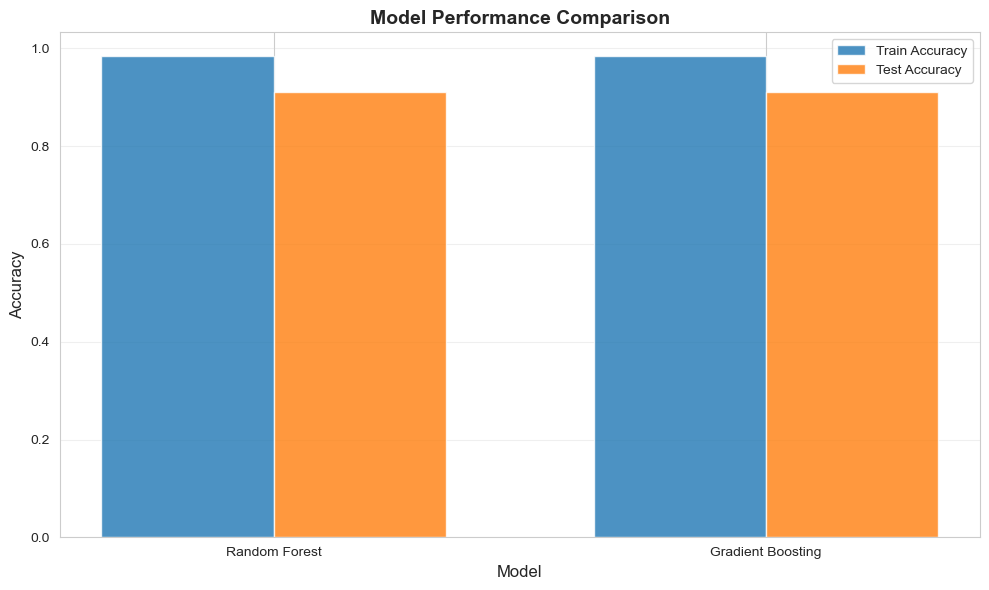


✓ Best Model: Random Forest


In [117]:
# Compare models
comparison_df = pd.DataFrame({
    'Model': list(models.keys()),
    'Train Accuracy': [models[m]['train_acc'] for m in models],
    'Test Accuracy': [models[m]['test_acc'] for m in models]
})

print("Model Performance Comparison:")
print("="*60)
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
x = np.arange(len(comparison_df))
width = 0.35

ax.bar(x - width/2, comparison_df['Train Accuracy'], width, label='Train Accuracy', alpha=0.8)
ax.bar(x + width/2, comparison_df['Test Accuracy'], width, label='Test Accuracy', alpha=0.8)

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Select best model
best_model_name = comparison_df.loc[comparison_df['Test Accuracy'].idxmax(), 'Model']
best_model = models[best_model_name]['model']
print(f"\n✓ Best Model: {best_model_name}")

### 3.2 Detailed Model Evaluation

Classification Report for Random Forest:
              precision    recall  f1-score   support

  Non-Winner       0.96      0.95      0.95       160
      Winner       0.11      0.12      0.12         8

    accuracy                           0.91       168
   macro avg       0.53      0.54      0.54       168
weighted avg       0.92      0.91      0.91       168



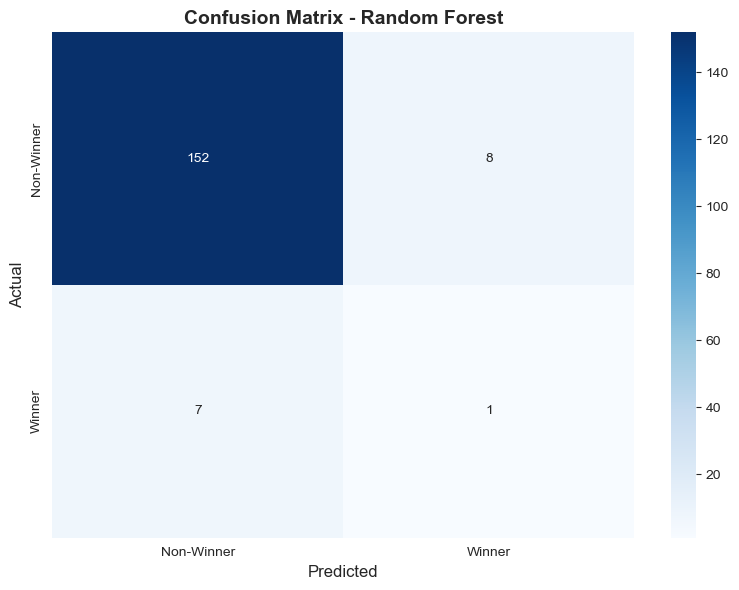

In [118]:
# Detailed evaluation for best model
best_model_pred = models[best_model_name]['test_pred']

print(f"Classification Report for {best_model_name}:")
print("="*60)
print(classification_report(y_test, best_model_pred, target_names=['Non-Winner', 'Winner']))

# Confusion Matrix
cm = confusion_matrix(y_test, best_model_pred)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Winner', 'Winner'], 
            yticklabels=['Non-Winner', 'Winner'], ax=ax)
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
ax.set_title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### 3.3 Feature Importance Analysis

Top 10 Most Important Features:
            Feature  Importance
       avg_position    0.196398
  starting_position    0.181653
    median_position    0.145540
    qualifying_time    0.080170
    circuit_encoded    0.073533
           dnf_rate    0.066786
      best_position    0.058429
started_from_podium    0.058056
  team_avg_position    0.047566
 team_best_position    0.038239


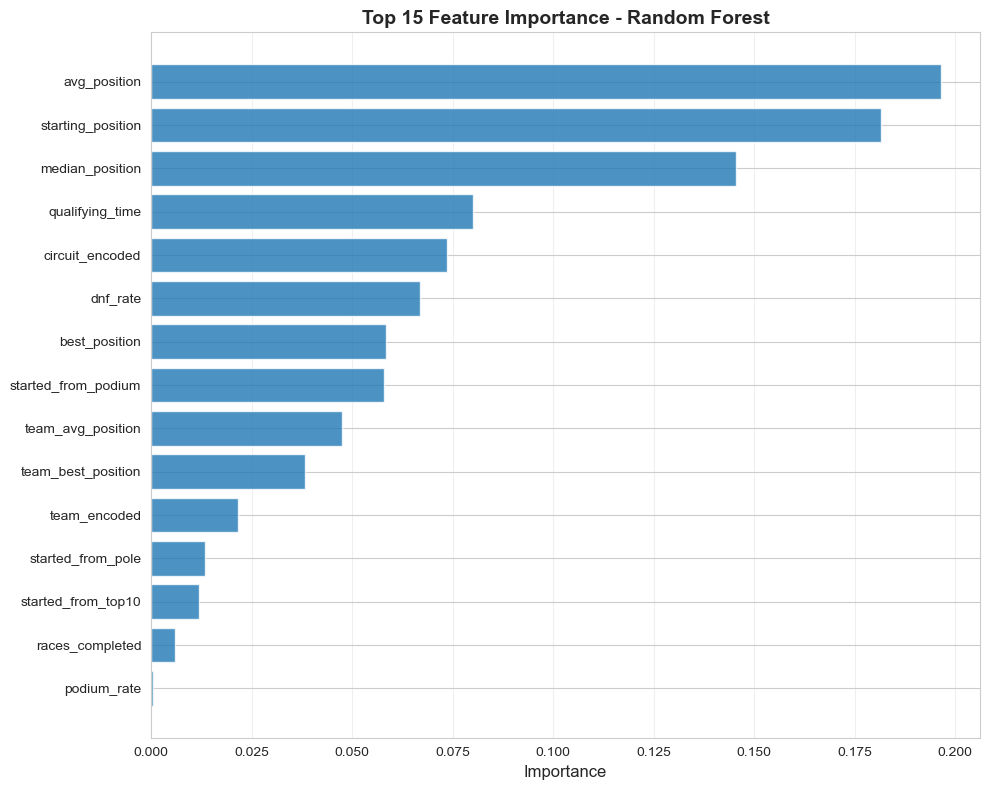

In [119]:
# Get feature importance from best model
feature_importance = pd.DataFrame({
    'Feature': feature_columns_final,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 10 Most Important Features:")
print("="*60)
print(feature_importance.head(10).to_string(index=False))

# Visualize feature importance
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
top_features = feature_importance.head(15)
ax.barh(range(len(top_features)), top_features['Importance'], alpha=0.8)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'])
ax.set_xlabel('Importance', fontsize=12)
ax.set_title(f'Top 15 Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

### 3.4 Win Probability Predictions for Each Race

In [120]:
# Create a function to predict race winner
def predict_race_winner(session_data, best_model, scaler, feature_cols, le_team, le_circuit):
    """
    Predict the winner of a race given session data
    
    Parameters:
    - session_data: DataFrame with driver information for upcoming race
    - best_model: Trained model
    - scaler: Fitted StandardScaler
    - feature_cols: List of feature column names
    - le_team: LabelEncoder for teams
    - le_circuit: LabelEncoder for circuits
    
    Returns:
    - DataFrame with predictions and probabilities
    """
    # Prepare features
    session_features = session_data[feature_cols].copy()
    session_features_scaled = scaler.transform(session_features)
    
    # Predict
    predictions = best_model.predict(session_features_scaled)
    probabilities = best_model.predict_proba(session_features_scaled)[:, 1]
    
    # Add results to dataframe
    results = session_data.copy()
    results['win_prediction'] = predictions
    results['win_probability'] = probabilities
    
    return results.sort_values('win_probability', ascending=False)

print("✓ Prediction function created")

✓ Prediction function created


In [121]:
# Example: Predict win probabilities for each race in test set
test_data = model_data.iloc[X_test.index].copy()
test_predictions = predict_race_winner(test_data, best_model, scaler, feature_columns_final, le_team, le_circuit)

# Display win probabilities for each race (show top 5 drivers per race)
print("Win Probability Predictions by Race:")
print("="*100)

for session_key in sorted(test_predictions['session_key'].unique())[:5]:  # Show first 5 races
    race_drivers = test_predictions[test_predictions['session_key'] == session_key].head(5)
    circuit = race_drivers.iloc[0]['circuit_short_name']
    country = race_drivers.iloc[0]['country_name']
    actual_winner = race_drivers[race_drivers['is_winner'] == 1]
    
    print(f"\n🏁 {country} - {circuit} (Session: {session_key})")
    if len(actual_winner) > 0:
        print(f"   Actual Winner: {actual_winner.iloc[0]['full_name']} ({actual_winner.iloc[0]['team_name']})")
    print(f"\n   {'Rank':<6} {'Driver':<25} {'Team':<20} {'Win Prob':<12} {'Start Pos':<10}")
    print(f"   {'-'*73}")
    
    for idx, (_, driver) in enumerate(race_drivers.iterrows(), 1):
        marker = "🏆" if driver['is_winner'] == 1 else "  "
        print(f"   {marker}{idx:<5} {driver['full_name']:<25} {driver['team_name'][:18]:<20} {driver['win_probability']:>6.2%}      {int(driver['starting_position']):<10}")

print(f"\n{'='*100}")

# Calculate how often highest probability driver actually wins
race_predictions = []
for session_key in test_predictions['session_key'].unique():
    race_drivers = test_predictions[test_predictions['session_key'] == session_key]
    top_driver = race_drivers.iloc[0]
    actual_winner = race_drivers[race_drivers['is_winner'] == 1]
    
    race_predictions.append({
        'session_key': session_key,
        'predicted_winner': top_driver['driver_number'],
        'actual_winner': actual_winner.iloc[0]['driver_number'] if len(actual_winner) > 0 else None,
        'top_prob': top_driver['win_probability'],
        'correct': len(actual_winner) > 0 and top_driver['driver_number'] == actual_winner.iloc[0]['driver_number']
    })

race_pred_df = pd.DataFrame(race_predictions)
total_count = len(race_pred_df)
correct_count = race_pred_df['correct'].sum()

print(f"\n📊 When picking driver with HIGHEST win probability:")
print(f"   Correct predictions: {correct_count}/{total_count} = {correct_count/total_count:.2%}")
print(f"   Average win probability of top pick: {race_pred_df['top_prob'].mean():.2%}")

Win Probability Predictions by Race:

🏁 Bahrain - Sakhir (Session: 9472)

   Rank   Driver                    Team                 Win Prob     Start Pos 
   -------------------------------------------------------------------------
     1     Lando NORRIS              McLaren              31.74%      7         
     2     Carlos SAINZ              Ferrari               0.50%      4         
     3     Alexander ALBON           Williams              0.00%      13        
     4     Nico HULKENBERG           Haas F1 Team          0.00%      10        

🏁 Saudi Arabia - Jeddah (Session: 9480)

   Rank   Driver                    Team                 Win Prob     Start Pos 
   -------------------------------------------------------------------------
     1     Charles LECLERC           Ferrari              18.73%      2         
     2     Oscar PIASTRI             McLaren               7.00%      5         
     3     Yuki TSUNODA              AlphaTauri            0.50%      9         
 

### 3.5 Visualize Predictions by Driver

Top 10 Drivers by Average Win Probability:
         Driver  Avg Win Probability  Actual Wins  Races
 Max VERSTAPPEN             0.560832            4     13
   Lando NORRIS             0.262035            0      7
 George RUSSELL             0.131817            1      8
Charles LECLERC             0.106032            0      8
  Oscar PIASTRI             0.105474            1     10
   Carlos SAINZ             0.080918            1     10
 Lewis HAMILTON             0.011252            1      8
   Pierre GASLY             0.001524            0      9
   Yuki TSUNODA             0.000625            0      8
Valtteri BOTTAS             0.000556            0      9


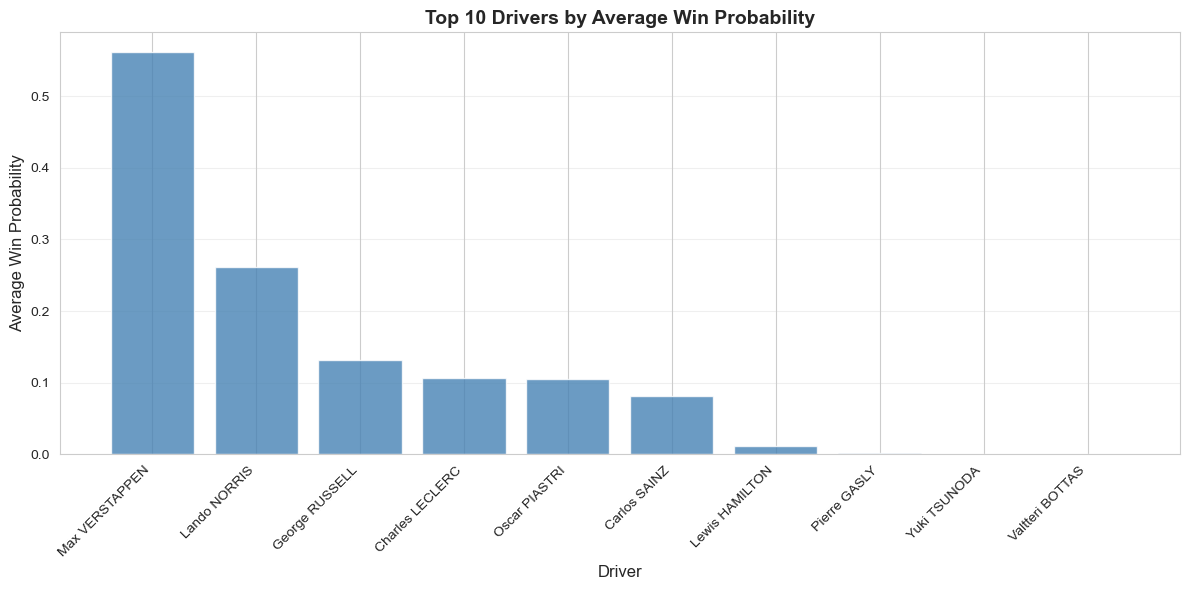

In [122]:
# Analyze win probability distribution by driver
driver_win_probs = test_predictions.groupby('full_name').agg({
    'win_probability': 'mean',
    'is_winner': 'sum',
    'session_key': 'count'
}).reset_index()

driver_win_probs.columns = ['Driver', 'Avg Win Probability', 'Actual Wins', 'Races']
driver_win_probs = driver_win_probs.sort_values('Avg Win Probability', ascending=False).head(10)

print("Top 10 Drivers by Average Win Probability:")
print("="*60)
print(driver_win_probs.to_string(index=False))

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
x = range(len(driver_win_probs))
ax.bar(x, driver_win_probs['Avg Win Probability'], alpha=0.8, color='steelblue')
ax.set_xlabel('Driver', fontsize=12)
ax.set_ylabel('Average Win Probability', fontsize=12)
ax.set_title('Top 10 Drivers by Average Win Probability', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(driver_win_probs['Driver'], rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 3.6 Win Probability Distribution by Circuit

Win Probability Statistics by Circuit:
Miami                Avg: 11.45%  Max: 94.65%  Std: 28.61%  Races: 2
Mexico City          Avg: 38.95%  Max: 77.59%  Std: 38.80%  Races: 1
Hungaroring          Avg: 30.01%  Max: 75.93%  Std: 37.01%  Races: 1
Interlagos           Avg:  4.96%  Max: 69.46%  Std: 18.56%  Races: 2
Shanghai             Avg:  4.35%  Max: 67.66%  Std: 16.89%  Races: 2
Spielberg            Avg: 12.70%  Max: 66.61%  Std: 24.01%  Races: 2
Las Vegas            Avg: 19.12%  Max: 54.98%  Std: 26.16%  Races: 1
Monza                Avg: 13.87%  Max: 43.24%  Std: 18.45%  Races: 1
Baku                 Avg:  8.62%  Max: 41.84%  Std: 15.96%  Races: 1
Silverstone          Avg:  6.53%  Max: 40.57%  Std: 14.05%  Races: 1
Austin               Avg:  6.51%  Max: 38.61%  Std: 13.70%  Races: 2
Sakhir               Avg:  8.06%  Max: 31.74%  Std: 15.79%  Races: 1
Lusail               Avg:  4.73%  Max: 27.24%  Std:  9.00%  Races: 2
Jeddah               Avg:  4.37%  Max: 18.73%  Std:  7.56%  Race

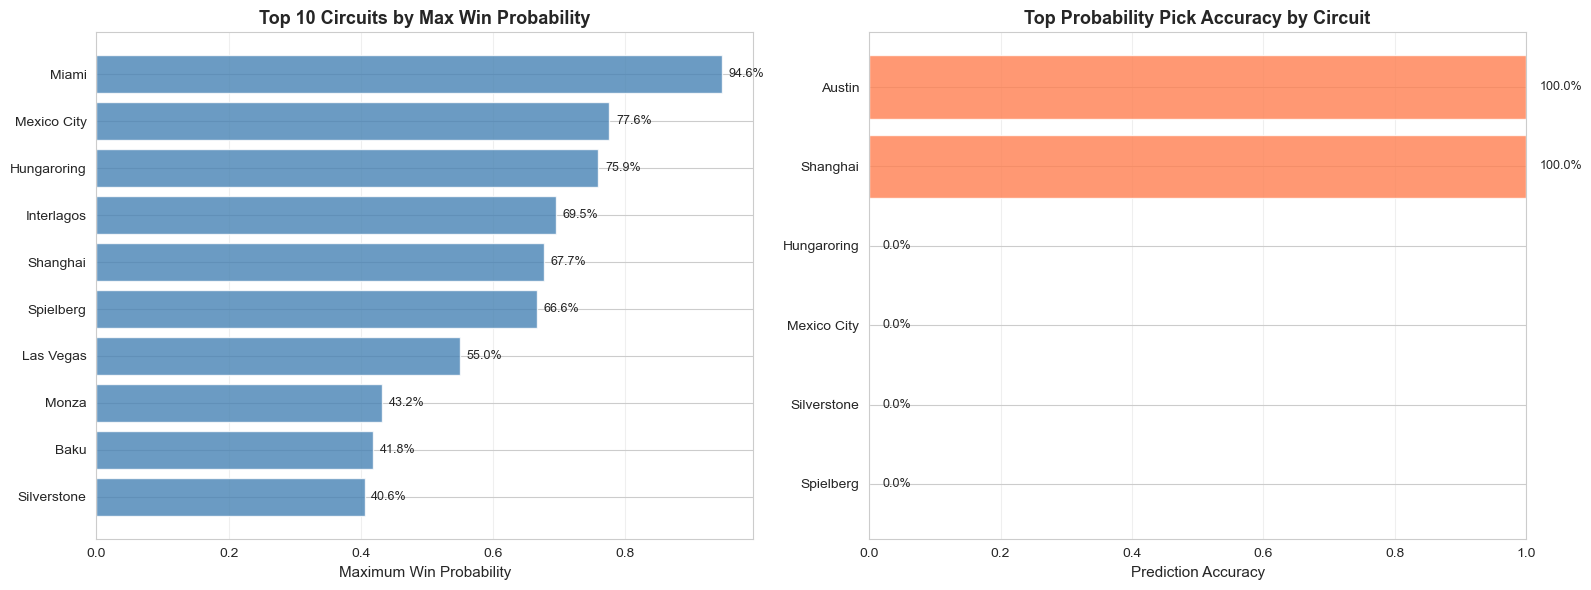

In [123]:
# Analyze win probability distribution by circuit
circuit_prob_stats = test_predictions.groupby('circuit_short_name').agg({
    'win_probability': ['mean', 'max', 'std'],
    'session_key': 'nunique'
}).reset_index()

circuit_prob_stats.columns = ['Circuit', 'Avg Win Prob', 'Max Win Prob', 'Std Win Prob', 'Num Races']
circuit_prob_stats = circuit_prob_stats.sort_values('Max Win Prob', ascending=False)

print("Win Probability Statistics by Circuit:")
print("="*80)
for _, row in circuit_prob_stats.iterrows():
    print(f"{row['Circuit']:<20} Avg: {row['Avg Win Prob']:>6.2%}  Max: {row['Max Win Prob']:>6.2%}  Std: {row['Std Win Prob']:>6.2%}  Races: {int(row['Num Races'])}")

# Calculate accuracy when using highest probability
accuracy_by_circuit = []
for session_key in test_predictions['session_key'].unique():
    race_drivers = test_predictions[test_predictions['session_key'] == session_key]
    circuit = race_drivers.iloc[0]['circuit_short_name']
    top_driver = race_drivers.iloc[0]
    actual_winner = race_drivers[race_drivers['is_winner'] == 1]
    
    if len(actual_winner) > 0:
        correct = top_driver['driver_number'] == actual_winner.iloc[0]['driver_number']
        accuracy_by_circuit.append({
            'circuit': circuit,
            'correct': correct
        })

accuracy_df = pd.DataFrame(accuracy_by_circuit)
circuit_accuracy = accuracy_df.groupby('circuit').agg({
    'correct': ['sum', 'count']
}).reset_index()

circuit_accuracy.columns = ['Circuit', 'Correct', 'Total']
circuit_accuracy['Accuracy'] = circuit_accuracy['Correct'] / circuit_accuracy['Total']
circuit_accuracy = circuit_accuracy.sort_values('Accuracy', ascending=False)

print(f"\n\nTop Probability Pick Accuracy by Circuit:")
print("="*60)
print(circuit_accuracy.to_string(index=False))

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Max win probability by circuit
top_circuits = circuit_prob_stats.head(10)
ax1.barh(range(len(top_circuits)), top_circuits['Max Win Prob'], alpha=0.8, color='steelblue')
ax1.set_yticks(range(len(top_circuits)))
ax1.set_yticklabels(top_circuits['Circuit'])
ax1.set_xlabel('Maximum Win Probability', fontsize=11)
ax1.set_title('Top 10 Circuits by Max Win Probability', fontsize=13, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

for i, v in enumerate(top_circuits['Max Win Prob']):
    ax1.text(v + 0.01, i, f'{v:.1%}', va='center', fontsize=9)

# Plot 2: Accuracy by circuit
ax2.barh(range(len(circuit_accuracy)), circuit_accuracy['Accuracy'], alpha=0.8, color='coral')
ax2.set_yticks(range(len(circuit_accuracy)))
ax2.set_yticklabels(circuit_accuracy['Circuit'])
ax2.set_xlabel('Prediction Accuracy', fontsize=11)
ax2.set_title('Top Probability Pick Accuracy by Circuit', fontsize=13, fontweight='bold')
ax2.set_xlim(0, 1)
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

for i, v in enumerate(circuit_accuracy['Accuracy']):
    ax2.text(v + 0.02, i, f'{v:.1%}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

### 3.7 Summary and Key Insights

In [124]:
# Final Summary
print("="*80)
print("F1 GRAND PRIX WIN PROBABILITY PREDICTION - SUMMARY")
print("="*80)

print(f"\n📊 DATASET STATISTICS:")
print(f"   • Total races analyzed: {len(race_data['session_key'].unique())}")
print(f"   • Total drivers: {len(race_data['driver_number'].unique())}")
print(f"   • Total race entries: {len(race_data)}")

print(f"\n🤖 MODEL PERFORMANCE:")
print(f"   • Best Model: {best_model_name}")
print(f"   • Test Accuracy: {models[best_model_name]['test_acc']:.2%}")
print(f"   • Top Probability Pick Accuracy: {correct_count/total_count:.2%}")
print(f"   • Avg Win Probability of Top Pick: {race_pred_df['top_prob'].mean():.2%}")

print(f"\n🏆 TOP PERFORMING DRIVERS (by avg win probability):")
for idx, row in driver_win_probs.head(5).iterrows():
    print(f"   {idx-driver_win_probs.index[0]+1}. {row['Driver']}: {row['Avg Win Probability']:.2%} (Actual Wins: {int(row['Actual Wins'])})")

print(f"\n🔑 KEY INSIGHTS:")
print(f"   • Most important feature: {feature_importance.iloc[0]['Feature']}")
print(f"   • Starting position impact: {'High' if feature_importance[feature_importance['Feature']=='starting_position']['Importance'].values[0] > 0.1 else 'Moderate'}")
print(f"   • Team performance matters: {'Yes' if any(feature_importance['Feature'].str.contains('team')) else 'No'}")

print(f"\n✅ MODEL PROVIDES WIN PROBABILITY FOR EACH DRIVER!")
print(f"   Use the predict_race_winner() function to get win probabilities for future races.")
print(f"   The model outputs probability scores (0-100%) for each driver in a race.")
print("="*80)

F1 GRAND PRIX WIN PROBABILITY PREDICTION - SUMMARY

📊 DATASET STATISTICS:
   • Total races analyzed: 30
   • Total drivers: 25
   • Total race entries: 839

🤖 MODEL PERFORMANCE:
   • Best Model: Random Forest
   • Test Accuracy: 91.07%
   • Top Probability Pick Accuracy: 6.67%
   • Avg Win Probability of Top Pick: 32.01%

🏆 TOP PERFORMING DRIVERS (by avg win probability):
   1. Max VERSTAPPEN: 56.08% (Actual Wins: 4)
   -2. Lando NORRIS: 26.20% (Actual Wins: 0)
   -5. George RUSSELL: 13.18% (Actual Wins: 1)
   -10. Charles LECLERC: 10.60% (Actual Wins: 0)
   3. Oscar PIASTRI: 10.55% (Actual Wins: 1)

🔑 KEY INSIGHTS:
   • Most important feature: avg_position
   • Starting position impact: High
   • Team performance matters: Yes

✅ MODEL PROVIDES WIN PROBABILITY FOR EACH DRIVER!
   Use the predict_race_winner() function to get win probabilities for future races.
   The model outputs probability scores (0-100%) for each driver in a race.
